In [379]:
import numpy as np
import pandas as pd
import data_collection as dc

import psycopg2
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

In [380]:
## code to open sql files. Dont need it now

# file_obj = open('../src/sql/05_pull_extr_rpsale_2019.sql')

# file_contents = file_obj.read()
# file_obj.close()

# file_contents
# df_test = pd.read_sql(file_contents, conn)

#### Import data

In [177]:
def import_data():
    dbname = "king_house"

    conn = psycopg2.connect(dbname = dbname)

    df_sale = pd.read_sql("""
    SELECT *

    FROM extr_rpsale
    """, conn)

    df_rdb = pd.read_sql("""
    SELECT *

    FROM extr_resbldg
    """, conn)

    df_parcel = pd.read_sql("""
    SELECT *

    FROM extr_parcel

    """, conn)

    df_lookup = pd.read_sql("""
    SELECT *

    FROM look_up

    """, conn)
    
    return df_sale, df_rdb, df_parcel, df_lookup

### Create tables

In [179]:
df_lookup = df_lookup[df_lookup['LUType'] != 'LUType']
df_lookup.head()

,LUType,LUItem,LUDescription
1,1,1,LAND ONLY ...
2,1,10,Land with new building ...
3,1,11,"Household, single family units ..."
4,1,12,"Multiple family residence (Residential, 2-4 un..."
5,1,13,"Multiple family residence (Residential, 5+ uni..."


In [348]:
# Selcted variables from the residenstial building dataset:

df_rdb = df_rdb[df_rdb['Major'] != 'Major']
df_rdb['HID'] = df_rdb['Major'].str.zfill(6) + '-'+ df_rdb['Minor'].str.zfill(4)

columns = ['Major', 'Minor', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',
            'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf', 'SqFtTotLiving',
            'SqFtTotBasement', 'SqFtFinBasement', 'FinBasementGrade','SqFtGarageBasement', 
            'SqFtGarageAttached', 'DaylightBasement','SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
            'Bedrooms','BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'HID']
df_rdb_set = df_rdb.loc[:, columns]
df_rdb_set.head()

,Major,Minor,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,...,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,HID
1,008400,0130,1800,0,460,0,0,0,2260,0,...,460,N,60,150,280,3,0,1,1,008400-0130
2,008400,0346,1340,0,0,0,0,0,1340,1340,...,0,Y,0,0,340,3,0,1,1,008400-0346
3,008700,0121,1410,0,0,0,0,0,1410,0,...,0,N,0,0,0,3,0,0,1,008700-0121
4,008700,0123,850,0,1140,0,0,0,1990,0,...,450,N,130,0,100,4,0,1,2,008700-0123
5,008700,0256,1370,0,0,0,0,0,1370,0,...,0,N,90,0,0,3,0,0,1,008700-0256


In [349]:
df_parcel.columns

Index(['.', 'Major', 'Minor', 'PropName', 'PlatName', 'PlatLot', 'PlatBlock',
       'Range', 'Township', 'Section', 'QuarterSection', 'PropType', 'Area',
       'SubArea', 'SpecArea', 'SpecSubArea', 'DistrictName', 'LevyCode',
       'CurrentZoning', 'HBUAsIfVacant', 'HBUAsImproved', 'PresentUse',
       'SqFtLot', 'WaterSystem', 'SewerSystem', 'Access', 'Topography',
       'StreetSurface', 'RestrictiveSzShape', 'InadequateParking',
       'PcntUnusable', 'Unbuildable', 'MtRainier', 'Olympics', 'Cascades',
       'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington',
       'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView', 'WfntLocation',
       'WfntFootage', 'WfntBank', 'WfntPoorQuality', 'WfntRestrictedAccess',
       'WfntAccessRights', 'WfntProximityInfluence', 'TidelandShoreland',
       'LotDepthFactor', 'TrafficNoise', 'AirportNoise', 'PowerLines',
       'OtherNuisances', 'NbrBldgSites', 'Contamination', 'DNRLease',
       'AdjacentGolfFairway', 'AdjacentGreenbe

In [350]:
# Selected variables from the parcel dataset:
df_parcel = df_parcel[df_parcel['Major'] != 'Major']
df_parcel['HID'] = df_parcel['Major'].str.zfill(6) + '-' + df_parcel['Minor'].str.zfill(4)

columns = ['Major', 'Minor', 'SqFtLot','WfntLocation', 
           'TrafficNoise', 'AirportNoise', 'PowerLines', 'HID'] 
df_parcel_set = df_parcel.loc[:, columns]
df_parcel_set.shape

#'PugetSound', 'LakeWashington','LakeSammamish', 'SmallLakeRiverCreek',

(614337, 8)

In [351]:
# Selseted variables from the property sale dataset: 

df_sale = df_sale[df_sale['Major'] != 'Major']

df_sale['HID'] = df_sale['Major'].str.zfill(6) + '-' + df_sale['Minor'].str.zfill(4)
df_sale_2019 = df_sale[df_sale['DocumentDate'].str.contains('2019')]

columns = ['Major', 'Minor', 'DocumentDate', 'SalePrice', 'PropertyType', 'HID']
df_sale_2019_set = df_sale_2019.loc[:, columns]
df_sale_2019_set.head()
df_sale_2019_set.shape

(60933, 6)

In [352]:
# Join 3 datasets together

df_combine = df_sale_2019_set.merge(df_parcel_set, how='inner', on='HID')
df_combine = df_combine.merge(df_rdb_set, how='inner', on='HID')

In [406]:
df_combine.columns
df_combine.shape

(43545, 35)

In [457]:
king_house_2019 = df_combine

In [458]:
king_house_2019.iloc[:, 0:10]

,Major_x,Minor_x,DocumentDate,SalePrice,PropertyType,HID,Major_y,Minor_y,SqFtLot,WfntLocation
0,213043,0120,12/20/2019,560000,11,213043-0120,213043,120,10523,0
1,940652,0630,07/22/2019,435000,11,940652-0630,940652,630,7392,0
2,797320,2320,03/27/2019,540000,3,797320-2320,797320,2320,8621,0
3,797320,2320,03/28/2019,0,3,797320-2320,797320,2320,8621,0
4,663990,0178,10/02/2019,0,3,663990-0178,663990,178,16144,0
...,...,...,...,...,...,...,...,...,...,...
43540,231430,0740,09/16/2019,700988,11,231430-0740,231430,740,8662,0
43541,192300,0170,09/03/2019,1550000,11,192300-0170,192300,170,20431,0
43542,757820,0400,07/19/2019,930000,11,757820-0400,757820,400,5000,0
43543,143800,0420,07/09/2019,695000,11,143800-0420,143800,420,4136,0


In [459]:
king_house_2019 = king_house_2019.astype(
                     {'SalePrice':'float',
                      'SqFtLot':'float',  
                      'SqFt1stFloor':'float', 
                       'SqFtHalfFloor':'float',
                       'SqFt2ndFloor':'float', 
                       'SqFtUpperFloor':'float', 
                       'SqFtUnfinFull':'float', 
                       'SqFtUnfinHalf':'float',
                       'SqFtTotLiving':'float', 
                       'SqFtTotBasement':'float', 
                       'SqFtFinBasement':'float',
                       'FinBasementGrade':'float', 
                       'SqFtGarageBasement':'float', 
                       'SqFtGarageAttached':'float',
                       'SqFtOpenPorch':'float', 
                       'SqFtEnclosedPorch':'float', 
                       'SqFtDeck':'float',
                       'Bedrooms':'float', 
                       'BathHalfCount':'float', 
                       'Bath3qtrCount':'float', 
                       'BathFullCount':'float'
                       }
                      )

In [460]:
king_house_2019.head()

,Major_x,Minor_x,DocumentDate,SalePrice,PropertyType,HID,Major_y,Minor_y,SqFtLot,WfntLocation,...,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount
0,213043,0120,12/20/2019,560000.0,11,213043-0120,213043,120,10523.0,0,...,0.0,550.0,,180.0,0.0,0.0,3.0,0.0,0.0,2.0
1,940652,0630,07/22/2019,435000.0,11,940652-0630,940652,630,7392.0,0,...,0.0,465.0,,45.0,0.0,0.0,3.0,0.0,2.0,1.0
2,797320,2320,03/27/2019,540000.0,3,797320-2320,797320,2320,8621.0,0,...,0.0,0.0,,0.0,0.0,0.0,3.0,1.0,1.0,1.0
3,797320,2320,03/28/2019,0.0,3,797320-2320,797320,2320,8621.0,0,...,0.0,0.0,,0.0,0.0,0.0,3.0,1.0,1.0,1.0
4,663990,0178,10/02/2019,0.0,3,663990-0178,663990,178,16144.0,0,...,0.0,660.0,,60.0,0.0,310.0,3.0,1.0,0.0,2.0


In [461]:
king_house_2019 = king_house_2019.drop(columns = ['Major_x', 'Major_y', 'Minor_x', 'Minor_y', 'DocumentDate', 'Major', 'Minor'])
# king_house_2019 = king_house_2019.drop(columns = 'DocumentData')

In [462]:
king_house_2019.describe()

,SalePrice,SqFtLot,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,...,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount
count,4.354500e+04,4.354500e+04,43545.000000,43545.000000,43545.000000,43545.000000,43545.000000,43545.000000,43545.000000,43545.000000,...,43545.000000,43545.000000,43545.000000,43545.000000,43545.000000,43545.000000,43545.000000,43545.000000,43545.000000,43545.000000
mean,5.949965e+05,5.344487e+04,1275.465702,48.072201,517.465886,14.404846,0.989827,0.674406,2153.741118,493.468504,...,2.871374,84.763325,255.663520,76.201998,5.889264,133.848823,3.423263,0.466047,0.511976,1.571179
std,1.167906e+06,8.889284e+05,522.108297,173.479475,675.018403,93.700479,26.742271,19.431964,1020.447668,599.544663,...,3.598955,193.551066,289.972797,143.786591,36.608694,216.955212,1.017325,0.542982,0.673199,0.725820
min,-3.000000e+02,3.750000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,5.043000e+03,950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1440.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000
50%,4.850000e+05,7.630000e+03,1210.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1960.000000,0.000000,...,0.000000,0.000000,160.000000,20.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000
75%,7.750000e+05,1.103900e+04,1510.000000,0.000000,1020.000000,0.000000,0.000000,0.000000,2660.000000,960.000000,...,7.000000,0.000000,480.000000,100.000000,0.000000,200.000000,4.000000,1.000000,1.000000,2.000000
max,6.250000e+07,2.330525e+07,8760.000000,2300.000000,5110.000000,1800.000000,1460.000000,1294.000000,11450.000000,5060.000000,...,20.000000,3060.000000,3210.000000,11570.000000,1840.000000,3220.000000,14.000000,10.000000,11.000000,7.000000


In [463]:
king_house_2019.iloc[:, 13:30].head(20)

king_house_2019['SqlTotal'] = king_house_2019['SqFt1stFloor'] + king_house_2019['SqFtHalfFloor'] + king_house_2019['SqFt2ndFloor']\
                         + king_house_2019['SqFtUpperFloor'] + king_house_2019['SqFtUnfinFull'] + king_house_2019['SqFtUnfinHalf']\
                         + king_house_2019['SqFtTotBasement'] + king_house_2019['SqFtFinBasement'] + king_house_2019['FinBasementGrade']\
                         + king_house_2019['SqFtGarageBasement'] + king_house_2019['SqFtGarageAttached'] \
                         + king_house_2019['SqFtOpenPorch'] + king_house_2019['SqFtEnclosedPorch'] + king_house_2019['SqFtDeck']

king_house_2019.head()


,SalePrice,PropertyType,HID,SqFtLot,WfntLocation,TrafficNoise,AirportNoise,PowerLines,SqFt1stFloor,SqFtHalfFloor,...,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,SqlTotal
0,560000.0,11,213043-0120,10523.0,0,0,0,N,1930.0,0.0,...,550.0,,180.0,0.0,0.0,3.0,0.0,0.0,2.0,2660.0
1,435000.0,11,940652-0630,7392.0,0,0,0,N,1057.0,0.0,...,465.0,,45.0,0.0,0.0,3.0,0.0,2.0,1.0,2485.0
2,540000.0,3,797320-2320,8621.0,0,0,0,N,860.0,0.0,...,0.0,,0.0,0.0,0.0,3.0,1.0,1.0,1.0,1626.0
3,0.0,3,797320-2320,8621.0,0,0,0,N,860.0,0.0,...,0.0,,0.0,0.0,0.0,3.0,1.0,1.0,1.0,1626.0
4,0.0,3,663990-0178,16144.0,0,0,0,N,1360.0,0.0,...,660.0,,60.0,0.0,310.0,3.0,1.0,0.0,2.0,3300.0


In [464]:
king_house_2019

,SalePrice,PropertyType,HID,SqFtLot,WfntLocation,TrafficNoise,AirportNoise,PowerLines,SqFt1stFloor,SqFtHalfFloor,...,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,SqlTotal
0,560000.0,11,213043-0120,10523.0,0,0,0,N,1930.0,0.0,...,550.0,,180.0,0.0,0.0,3.0,0.0,0.0,2.0,2660.0
1,435000.0,11,940652-0630,7392.0,0,0,0,N,1057.0,0.0,...,465.0,,45.0,0.0,0.0,3.0,0.0,2.0,1.0,2485.0
2,540000.0,3,797320-2320,8621.0,0,0,0,N,860.0,0.0,...,0.0,,0.0,0.0,0.0,3.0,1.0,1.0,1.0,1626.0
3,0.0,3,797320-2320,8621.0,0,0,0,N,860.0,0.0,...,0.0,,0.0,0.0,0.0,3.0,1.0,1.0,1.0,1626.0
4,0.0,3,663990-0178,16144.0,0,0,0,N,1360.0,0.0,...,660.0,,60.0,0.0,310.0,3.0,1.0,0.0,2.0,3300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43540,700988.0,11,231430-0740,8662.0,0,0,0,N,1580.0,0.0,...,710.0,,70.0,0.0,220.0,5.0,0.0,1.0,2.0,3790.0
43541,1550000.0,11,192300-0170,20431.0,0,0,0,N,2050.0,0.0,...,50.0,Y,100.0,0.0,180.0,3.0,1.0,1.0,3.0,6029.0
43542,930000.0,11,757820-0400,5000.0,0,0,0,N,1300.0,0.0,...,0.0,N,0.0,0.0,0.0,3.0,0.0,0.0,2.0,3907.0
43543,695000.0,11,143800-0420,4136.0,0,0,0,N,1000.0,0.0,...,520.0,N,350.0,0.0,0.0,4.0,1.0,0.0,2.0,3390.0


In [465]:
cols = list(king_house_2019.columns)
cols = [cols[2]] + cols[:2] + cols[3:]
king_house_2019 = king_house_2019[cols]


In [466]:
king_house_2019['PorchTotal']=king_house_2019.SqFtOpenPorch + king_house_2019.SqFtEnclosedPorch

<ipython-input-466-5088e69a5cbb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  king_house_2019['PorchTotal']=king_house_2019.SqFtOpenPorch + king_house_2019.SqFtEnclosedPorch


In [467]:
king_house_2019['is_waterfront'] = (king_house_2019['WfntLocation'] != '0').astype(int)

<ipython-input-467-0502e04d5ff1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  king_house_2019['is_waterfront'] = (king_house_2019['WfntLocation'] != '0').astype(int)


In [468]:
king_house_2019['WfntLocation'].value_counts()

0    42528
6      267
8      234
3      208
9      206
7       80
5       14
1        7
4        1
Name: WfntLocation, dtype: int64

In [469]:
df_lookup_w = df_lookup[df_lookup['LUType']=='55 ']

df_lookup_w

,LUType,LUItem,LUDescription
985,55,1,RESTRICTED ...
986,55,2,LEGAL/UNDEVELOPED ...
987,55,3,PRIVATE ...
988,55,4,PUBLIC ...
989,55,5,WALK IN ...


In [472]:
king_house_2019['PorchTotal'] = king_house_2019['SqFtOpenPorch'] + king_house_2019['SqFtEnclosedPorch']
king_house_2019['is_porch'] = (king_house_2019['PorchTotal']==0).astype('int')

<ipython-input-472-528c59207cf6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  king_house_2019['PorchTotal'] = king_house_2019['SqFtOpenPorch'] + king_house_2019['SqFtEnclosedPorch']
<ipython-input-472-528c59207cf6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  king_house_2019['is_porch'] = (king_house_2019['PorchTotal']==0).astype('int')


In [473]:
king_house_2019.columns

Index(['HID', 'SalePrice', 'PropertyType', 'SqFtLot', 'WfntLocation',
       'TrafficNoise', 'AirportNoise', 'PowerLines', 'SqFt1stFloor',
       'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor', 'SqFtUnfinFull',
       'SqFtUnfinHalf', 'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'Bedrooms', 'BathHalfCount', 'Bath3qtrCount', 'BathFullCount',
       'SqlTotal', 'PorchTotal', 'is_waterfront', 'is_porch'],
      dtype='object')

In [489]:
def correlation_fig(df):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    fig1, ax1 = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, mask=mask, ax=ax1)

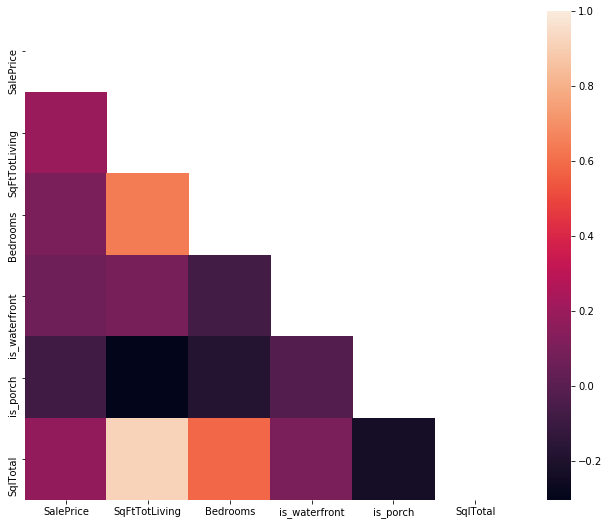

In [479]:
columns = ['SalePrice', 'PropertyType','SqFtTotLiving', 'Bedrooms', 'is_waterfront', 'is_porch', 'SqlTotal']
df = king_house_2019[columns]
colrelation = correlation(df)

In [487]:
def model_test (df): 
    df.dropna(inplace=True)
    model = ols(formula="df.iloc[:, 0] ~ df.iloc[:, 1:]", data = df).fit()
    
    return model.summary()


In [484]:
# fsm_df = df[["Schooling", "Life_Expectancy"]].copy()

In [488]:
kh_base = king_house_2019[['SalePrice', 'SqlTotal']].copy() 

model_test(kh_base)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          df.iloc[:, 0]   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1323.
Date:                Tue, 03 Mar 2020   Prob (F-statistic):          2.43e-285
Time:                        16:26:40   Log-Likelihood:            -6.6949e+05
No. Observations:               43545   AIC:                         1.339e+06
Df Residuals:                   43543   BIC:                         1.339e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.994e+05   1.22e+04     16.349      0.000    1.75e+05    2.23e+05
df.iloc[:, 1:]   123.2477      3.389     36.370      0.000     116.606     129.890
==============================================================================
Omnibus:                    84794.254   Durbin-Watson:                   0.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        288724793.540
Skew:                          15.367   Prob(JB):                         0.00
Kurtosis:                     400.728   Cond. No.                     7.96e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
### Check 